

**Практика 8: Методы защиты от атак на модели ИИ**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Защита с помощью Adversarial Training

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Изменение формы данных для работы с Keras
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Создание модели
def create_model():
    model = Sequential([
        tf.keras.Input(shape=(28, 28, 1)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Генерация adversarial-примеров с использованием метода FGSM
def generate_adversarial_examples(model, images, labels, epsilon):
    # Преобразование массивов в tf.Tensor
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, images)
    adversarial_images = images + epsilon * tf.sign(gradients)
    adversarial_images = tf.clip_by_value(adversarial_images, 0.0, 1.0)
    return adversarial_images

# Функция для adversarial-тренировки
def adversarial_training(model, images, labels, epsilon=0.1, epochs=1):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Генерируем adversarial-примеры
        adversarial_images = generate_adversarial_examples(model, images, labels, epsilon)
        adversarial_images = tf.convert_to_tensor(adversarial_images)
        model.fit(adversarial_images, labels, epochs=1, verbose=1)


# Инициализация и тренировка модели
model = create_model()

# Тренировка модели с использованием adversarial-примеров
adversarial_training(model, train_images, train_labels, epsilon=0.1, epochs=3)

# Оценка модели
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Сохранение модели
model.save('adversarial_trained_model.h5')


Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8902 - loss: 0.4332
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8888 - loss: 0.6303
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8979 - loss: 0.5713


Test Loss: 0.5883, Test Accuracy: 0.8049


Шаг 2: Градиентная маскировка (Gradient Masking)

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Изменение формы данных для работы с Keras
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Преобразование меток в one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Обновление модели для градиентной маскировки
def create_masked_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10),
        Activation('softplus')  # Используем softplus вместо softmax для градиентной маскировки
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Инициализация модели с градиентной маскировкой
masked_model = create_masked_model()

# Обучение модели с градиентной маскировкой
masked_model.fit(train_images, train_labels, epochs=5)

# Оценка модели
loss, accuracy = masked_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Сохранение модели с градиентной маскировкой
masked_model.save('masked_model.h5')


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8762 - loss: 0.4599
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9621 - loss: 0.1342
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9740 - loss: 0.0859
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9799 - loss: 0.0669
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9847 - loss: 0.0506


Test Loss: 0.0784, Test Accuracy: 0.9768


Шаг 3: Регуляризация и нормализация для повышения устойчивости

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Изменение формы данных для работы с Keras
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Преобразование меток в one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Модель с регуляризацией и нормализацией
def create_regularized_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),  # Dropout для борьбы с переобучением
        BatchNormalization(),  # Нормализация
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Инициализация модели с регуляризацией и нормализацией
regularized_model = create_regularized_model()

# Обучение модели с регуляризацией и нормализацией
regularized_model.fit(train_images, train_labels, epochs=5)

# Оценка модели
loss, accuracy = regularized_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Сохранение модели с регуляризацией
regularized_model.save('regularized_model.h5')


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7938 - loss: 1.3442
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8704 - loss: 0.6297
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8651 - loss: 0.6236
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8651 - loss: 0.6164
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8628 - loss: 0.6208


Test Loss: 0.3977, Test Accuracy: 0.9347


Шаг 4: Оценка моделей на противоречивых примерах

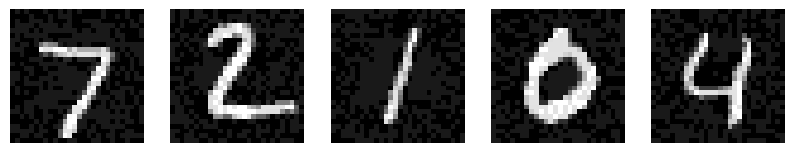

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 10.8206
Accuracy of protected model on adversarial examples: 0.0
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7836 - loss: 0.6495
Accuracy of protected model on original test data: 0.8048999905586243


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Загрузка атакованной модели
protected_model = tf.keras.models.load_model('adversarial_trained_model.h5')
protected_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

if len(test_labels.shape) > 1:
    sparse_test_labels = np.argmax(test_labels, axis=1)
else:
    sparse_test_labels = test_labels

# Генерация противоречивых примеров для тестовых данных
adversarial_test_images = generate_adversarial_examples(
    protected_model,
    test_images,
    sparse_test_labels,  # Передаем sparse метки
    epsilon=0.1
)

# Визуализация нескольких adversarial-примеров
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axes[i].imshow(adversarial_test_images[i].numpy().reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()

# Оценка модели на противоречивых примерах
test_loss, test_acc = protected_model.evaluate(adversarial_test_images, sparse_test_labels)
print(f'Accuracy of protected model on adversarial examples: {test_acc}')

# Оценика модели на обычных тестовых данных
test_loss_normal, test_acc_normal = protected_model.evaluate(test_images, sparse_test_labels)
print(f'Accuracy of protected model on original test data: {test_acc_normal}')


Шаг 5: Сравнение методов защиты

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Изменение формы данных для работы с Keras
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Преобразование меток в one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Генерация adversarial-примеров с использованием метода FGSM
def generate_adversarial_examples(model, images, labels, epsilon):
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, images)
    adversarial_images = images + epsilon * tf.sign(gradients)
    adversarial_images = tf.clip_by_value(adversarial_images, 0.0, 1.0)
    return adversarial_images

# Загрузка и компиляция моделей
adversarial_model = load_model('adversarial_trained_model.h5')
adversarial_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

masked_model = load_model('masked_model.h5')
masked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

regularized_model = load_model('regularized_model.h5')
regularized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Оценка каждой модели на обычных тестовых данных
def evaluate_model(model, model_name, test_images, test_labels):
    print(f"\nEvaluating {model_name} on original test data")
    loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

# Оценка каждой модели на противоречивых данных
def evaluate_model_adversarial(model, model_name, test_images, test_labels, epsilon=0.1):
    adversarial_test_images = generate_adversarial_examples(model, test_images, test_labels, epsilon)
    print(f"\nEvaluating {model_name} on adversarial test data")
    loss, accuracy = model.evaluate(adversarial_test_images, test_labels, verbose=0)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

# Оценка моделей
evaluate_model(adversarial_model, "Adversarial Training Model", test_images, test_labels)
evaluate_model_adversarial(adversarial_model, "Adversarial Training Model", test_images, test_labels)

evaluate_model(masked_model, "Gradient Masking Model", test_images, test_labels)
evaluate_model_adversarial(masked_model, "Gradient Masking Model", test_images, test_labels)

evaluate_model(regularized_model, "Regularized Model", test_images, test_labels)
evaluate_model_adversarial(regularized_model, "Regularized Model", test_images, test_labels)



Evaluating Adversarial Training Model on original test data
Loss: 0.5883059501647949, Accuracy: 0.8048999905586243

Evaluating Adversarial Training Model on adversarial test data
Loss: 10.59511661529541, Accuracy: 0.0

Evaluating Gradient Masking Model on original test data
Loss: 0.0783783420920372, Accuracy: 0.9768000245094299

Evaluating Gradient Masking Model on adversarial test data
Loss: 6.396913528442383, Accuracy: 0.11999999731779099

Evaluating Regularized Model on original test data
Loss: 0.3976946175098419, Accuracy: 0.9347000122070312

Evaluating Regularized Model on adversarial test data
Loss: 1.7072527408599854, Accuracy: 0.4772999882698059


Вывод:

Adversarial Training показала свою слабость в защите от атак, несмотря на высокие результаты на обычных данных. Возможно, улучшение данной методики с учётом более сложных атак могло бы повысить её эффективность.

Gradient Masking оказалась эффективной для обычных данных, но не показала значительной защиты от атак, что может указывать на её уязвимость.

Regularization имеет лучшие результаты, чем другие методы защиты, но всё равно не идеальна в защите от атак, что открывает возможности для дальнейших улучшений.
